# Home Assignment No. 2

To solve this task, you will write a lot of code to try several machine learning methods for classification and regression.
* You are **HIGHLY RECOMMENDED** to read relevant documentation, e.g. for [python](https://docs.python.org/3/), [numpy](https://docs.scipy.org/doc/numpy/reference/), [matlpotlib](https://matplotlib.org/) and [sklearn](https://scikit-learn.org/stable/). Also remember that seminars, lecture slides, [Google](http://google.com) and [StackOverflow](https://stackoverflow.com/) are your close friends during this course (and, probably, whole life?).

* If you want an easy life, you have to use **BUILT-IN METHODS** of `sklearn` library instead of writing tons of your own code. There exists a class/method for almost everything you can imagine (related to this homework).

* You have to write **CODE** directly inside specified places marked by comments: **BEGIN/END Solution**. Do not create new cells.

* In some problems you are asked to provide a short discussion of the results. For that find the specific place marked via **Your text answer: \<write your answer\>**.

* For every separate problem or subproblem (if specified) you can get only 0 points or maximal points for this problem. There are **NO INTERMEDIATE scores**. So make sure that you did everything required in the task.

* Your **SOLUTION** notebook **MUST BE REPRODUCIBLE**, i.e., if the reviewer decides to restart the notebook and run all cells, after all the computation he will obtain exactly the same solution (with all the corresponding plots) as in your uploaded notebook. For this purpose, we suggest fixing random `seed` or (better) define `random_state=` inside every algorithm that uses some pseudorandomness.

* Your code must be clear to the reviewer. For this purpose, try to include necessary comments inside the code. But remember: **GOOD CODE MUST BE SELF-EXPLANATORY** without any additional comments.

* Many `sklearn` algorithms support multithreading (Ensemble Methods, Cross-Validation, etc.). Check if the particular algorithm has `n_jobs` parameters and set it to `-1` to use all the cores.


## Task 1. Deep ANNs. (3 points)

-  **(1 pt.)** Activation functions; **(sub tasks 1.1)**
-  **(2 pt.)** MNIST classification.  **(sub tasks 1.2)**



### Task 1.1.  Activation functions. 
Plot the following [activation functions](https://pytorch.org/docs/master/nn.html#non-linear-activation-functions) using their PyTorch implementation and their derivatives using [autograd](https://pytorch.org/docs/stable/autograd.html) functionality `grad()`:
   
1. Plot `ReLU`, `ELU` ($\alpha = 1$), `Softplus` ($\beta = 1$) and `Sign`, `Sigmoid`, `Softsign`, `Tanh`.

Hint: you should get something like 
<img src="https://drive.google.com/uc?export=view&id=10yYRwZgCDzaxfUVvvkL9nSIpqy6brNpr" width="500"/>

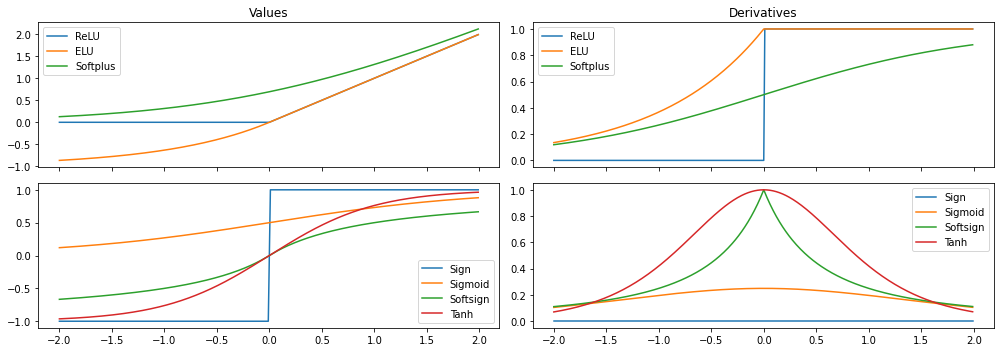

In [1]:
%matplotlib inline
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch

x = torch.arange(-2, 2, .01, requires_grad=True)
x_np = x.detach().numpy()
x.sum().backward() # to create x.grad

f, axes = plt.subplots(2, 2, sharex=True, figsize=(14, 5))
axes[0, 0].set_title('Values')
axes[0, 1].set_title('Derivatives')

names = []

for i, function_set in (0, (('ReLU', F.relu), ('ELU', F.elu), ('Softplus', F.softplus))), \
                       (1, (('Sign', torch.sign), ('Sigmoid', torch.sigmoid), ('Softsign', F.softsign), ('Tanh', torch.tanh))):
    for function_name, activation in function_set:
        ### BEGIN Solution
        y=activation(x)
        axes[i,0].plot(x_np,y.detach().numpy(),label=function_name)
        axes[i,1].plot(x_np,torch.autograd.grad(inputs=x,outputs=y,grad_outputs=torch.ones_like(y))[0].detach().numpy(),label=function_name)

        ### END Solution

    axes[i, 0].legend()
    axes[i, 1].legend()

plt.tight_layout()
plt.show()

### Task 1.2. MNIST classification. 

At one of the seminars we have discussed an MLP (Multilayer perceptron) with one hidden layer, logistic activation functions and softmax. In this task, you are to:

1. Implement the MLP modules, including the Softmax cross entropy between `logits` and `labels` using numpy.

2.  Train your numpy realization of MLP to classify the MNIST from `sklearn.datasets()`. The required accuracy on validation is `> 90%`.

3. Derive the confusion matrix for all digits classes. Which digits are predicted better or worse than others, why?

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

/Users/aleksandra/.local/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [55]:
# fetch the dataset.
digits, targets = load_digits(return_X_y=True)
digits = digits.astype(np.float32) / 255

digits_train, digits_test, targets_train, targets_test = train_test_split(digits, targets, random_state=0)

train_size = digits_train.shape[0]
test_size = digits_test.shape[0]

input_size = 8*8
classes_n = 10

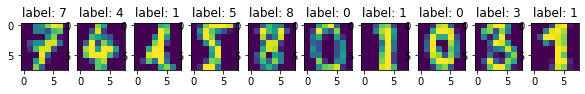

In [56]:
N = 10

sample_idx = np.random.choice(1797, N, replace=False)
digits_sample = digits[sample_idx]
targets_sample = targets[sample_idx]
f, ax  = plt.subplots(1,10, figsize=(10, 5))

for i in range(N):
    ax[i].imshow(digits_sample[i].reshape(8,8))
    ax[i].set_title('label: '+str(targets_sample[i]))

A short recap on what we are going to achieve here.
<br>
1. Forward pass:
$$
h_1 = X\theta_1+\beta_1
$$

$$
O_1 = sig(h_1)
$$

$$
h_2 = O_1\theta_2+\beta_2
$$
$$
O_2 = softmax(h_2)
$$
$$
Loss = CrossEntropy(O_2, true \space labels)
$$

2. Compute gradients: 

To update weights first we need to compute loss gradients with respect to $\theta_1$ and $\theta_2$ and then update both $\theta$ and $\beta$.

$$
\frac{ \partial{loss} }{\partial{\theta_2}} = \frac{ \partial{loss} }{\partial{O_2}}\frac{ \partial{O_2} }{\partial{h_2}}\frac{ \partial{h_2} }{\partial{\theta_2}}
$$
Note, that $\frac{ \partial{h_2} }{\partial{\theta_2}}=O_1$, so we can cache this value during forward pass to speed up our computation.
$$
\frac{ \partial{loss} }{\partial{\theta_1}} = \frac{ \partial{loss} }{\partial{O_2}}\frac{ \partial{O_2} }{\partial{h_2}}\frac{ \partial{h_2} }{\partial{O_1}}\frac{ \partial{O_1} }{\partial{h_1}}\frac{ \partial{h_1} }{\partial{\theta_1}}
$$
Note, that $\frac{ \partial{h_1} }{\partial{\theta_1}}=X$.

Since we are using sigmoid avtivation function here and
$$
\frac{ \partial{sig} }{\partial{h}} = sig(h)(1 - sig(h))
$$
It also makes sense to cache sig(h) during forward pass.
3. Update weights:

$\theta:= \theta -  \frac{ \partial{loss} }{\partial{\theta}}\alpha$, where $\alpha$ is some learning rate.

Note, it was not shown here how to update and compute $\beta$ but you can do it!

### Implement the MLP with backprop

In [68]:
### YOUR TASK STARTS HERE ###

#Here you should implement by yourself MLP class and its constituents including forward and backward propagation methods

class Linear:
    def __init__(self, input_size, output_size):
        # Trainable parameters of the layer and their gradients
        self.W = np.random.randn(input_size, output_size) # the weight matrix of the layer (W)
        self.dLdW = np.empty_like(self.W) # gradient w.r.t. the weight matrix of the layer
        self.b = np.random.randn(output_size) # bias terms of the layer (b)
        self.dLdb = np.empty_like(self.b) # gradient w.r.t. bias terms of the linear layer

    def forward(self, X): 
        #keep x for backward computation
        #X is np.array of size (N, input_size).
        #Returns output of size (N, output_size).
        self.X = X
        y = np.matmul(X, self.W) + self.b
        return y
    
    def backward(self, dLdy, learning_rate):
        """
        Calculate and return gradient of the loss w.r.t. the input of linear layer given the input x and the gradient 
        w.r.t output of linear layer. You should also calculate and update gradients of layer parameters.
        :param x: np.array, input tensor for linear layer;
        :param output_grad: np.array, grad tensor w.r.t output of linear layer;
        :return: np.array, grad w.r.t input of linear layer
        """
        
        ### BEGIN Solution
        # ... calculate grads
        # >>> your solution here <<<
        
        #y = WX + b
        #dLdW = dLdy * dydw
        self.dLdW = (dLdy.T @ self.X).T
        self.dLdb = (dLdy.T@np.ones(dLdy.shape[0]).reshape(-1,1)).flatten()
        dLdx =  dLdy @ self.W.T
        return dLdx
        ### END Solution


    def step(self, learning_rate):
        self.W -= self.dLdW * learning_rate
        self.b -= self.dLdb * learning_rate

class LogisticActivation:
    def __init__(self):
        # the layer has no parameters
        pass 
        
    def sig(self, x):
        return 1/(1 + np.exp(-x))

    def forward(self, x):
        # keep o for backward computation
        self.y = self.sig(x)
        return self.y 


    def backward(self,  dLdy, learning_rate=None):
        """
        Calculate and return the gradient of the loss w.r.t. the input
        of logistic non-linearity (given input x and the gradient 
        w.r.t output of logistic non-linearity).
        
        :param x: np.array, input tensor for logistic non-linearity;
        :param output_grad: np.array, grad tensor w.r.t output of logistic non-linearity;
        :return: np.array, grad w.r.t input of logistic non-linearity
        
        """
        
        ### BEGIN Solution
        # >>> your solution here <<<
        dLdx = dLdy * self.y * (1 - self.y)
        return dLdx
        ### END Solution
        


class MLP:
    def __init__(self, input_size, hidden_layer_size, output_size):
        self.linear1 = Linear(input_size, hidden_layer_size)
        self.activation1 = LogisticActivation()
        self.linear2 = Linear(hidden_layer_size, output_size)
        
    def forward(self, x):
        y1 = self.linear1.forward(x)
        y1a = self.activation1.forward(y1)
        y2 = self.linear2.forward(y1a)
        return y2

    def backward(self, dLdy, learning_rate):
        """
        Calculate and return the gradient of the loss w.r.t. the input of MLP given the input and the gradient 
        w.r.t output of MLP. You should also update gradients of paramerters of MLP layers.
        Hint - you should chain backward operations of modules you have already implemented. You may also
        need to calculate intermediate forward results.
        
        :param x: np.array, input tensor for MLP;
        :param output_grad: np.array, grad tensor w.r.t output of MLP;
        :return: np.array, grad w.r.t input of MLP
        """
 
        ### BEGIN Solution
        # >>> your solution here <<<
        dLdy1a = self.linear2.backward(dLdy, learning_rate)
        self.linear2.step(learning_rate)
        dLdy1 = self.activation1.backward(dLdy1a, learning_rate)
        dLdx = self.linear1.backward(dLdy1, learning_rate)
        self.linear1.step(learning_rate)
        return dLdx
        ### END Solution



In [74]:
### BEGIN Solution
def softmax_crossentropy_with_logits(y, y_true):    
    # >>> your solution here <<<
    
    probabilities = np.exp(y)/np.sum(np.exp(y))
    loss = -np.sum(y_true*np.log(probabilities))
    return loss
    ### END Solution

def grad_softmax_crossentropy_with_logits(y, y_true):
    # >>> your solution here <<<
    probabilities = np.exp(y)/np.sum(np.exp(y))
    grad = (y_true.sum())*(probabilities - y_true)
    return grad
    ### END Solution 

### END Solution

In [75]:
np.random.seed(42)

mlp = MLP(input_size=input_size, hidden_layer_size=100, output_size=classes_n)

epochs_n = 100
learning_curve = [0] * epochs_n
test_curve = [0] * epochs_n

x_train = digits_train
x_test = digits_test
y_train = targets_train
y_test = targets_test

learning_rate = 1e-2

for epoch in range(epochs_n):
    
    y_pred = []

    for sample_i in range(train_size):
        x = x_train[sample_i].reshape((1, -1))
        target = np.array([y_train[sample_i]])
        y = mlp.forward(x)

        ### BEGIN Solution
        # ... zero the gradients of the model
        # ... perform forward pass and compute the loss
        # ... compute the gradients w.r.t. the input of softmax layer
        # ... perform backward pass
        # ... and update the weights with weight -= grad * learning_rate
        

        # >>> your solution here <<<
        y_true = np.zeros(classes_n)
        y_true[target[0]] = 1
        loss = softmax_crossentropy_with_logits(y,y_true)
        dLdy = grad_softmax_crossentropy_with_logits(y, y_true)
        mlp.backward(dLdy, learning_rate)


        y_pred.extend(y.argmax(1))

    if epoch % 10 == 0:
        
        y_pred_test = []

        for sample_i in range(test_size):
            x = x_test[sample_i].reshape((1, -1))
            target = np.array([y_test[sample_i]])
            logits = mlp.forward(x)
            y_pred_test.extend(logits.argmax(1))

        print('Starting epoch {}'.format(epoch), \
              ', Loss : {:.3}'.format(loss), \
              ', Accuracy on train: {:.3}'.format(accuracy_score(y_train, y_pred)), \
              ', Accuracy on test: {:.3}'.format(accuracy_score(y_test, y_pred_test)) )
        
    ### END Solution

Starting epoch 0 , Loss : 2.71 , Accuracy on train: 0.103 , Accuracy on test: 0.0667
Starting epoch 10 , Loss : 2.15 , Accuracy on train: 0.625 , Accuracy on test: 0.649
Starting epoch 20 , Loss : 1.55 , Accuracy on train: 0.821 , Accuracy on test: 0.807
Starting epoch 30 , Loss : 1.07 , Accuracy on train: 0.875 , Accuracy on test: 0.871
Starting epoch 40 , Loss : 0.742 , Accuracy on train: 0.9 , Accuracy on test: 0.889
Starting epoch 50 , Loss : 0.534 , Accuracy on train: 0.911 , Accuracy on test: 0.904
Starting epoch 60 , Loss : 0.399 , Accuracy on train: 0.92 , Accuracy on test: 0.924
Starting epoch 70 , Loss : 0.308 , Accuracy on train: 0.927 , Accuracy on test: 0.931
Starting epoch 80 , Loss : 0.245 , Accuracy on train: 0.929 , Accuracy on test: 0.931
Starting epoch 90 , Loss : 0.198 , Accuracy on train: 0.936 , Accuracy on test: 0.933


In [76]:
# confusion matrix
# >>> your solution here <<<
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred_test))

[[37  0  0  0  0  0  0  0  0  0]
 [ 0 39  0  0  0  0  2  0  0  2]
 [ 0  2 40  1  0  0  0  1  0  0]
 [ 0  0  0 42  0  0  0  1  1  1]
 [ 0  0  0  0 37  0  0  1  0  0]
 [ 0  0  0  0  0 46  0  0  0  2]
 [ 0  1  0  0  0  0 51  0  0  0]
 [ 0  0  0  0  0  0  0 48  0  0]
 [ 0  4  1  0  0  1  0  1 41  0]
 [ 0  0  0  4  0  2  0  1  1 39]]


## Task 2. Autoencoders on tabular data (2 points)
**From now on we will be using pytorch for all the tasks.**

We will build a latent representation for tabular data with simple Autoencoder (AE). We are going to work with the cancer dataset from scikit-learn package. You are to follow the instructions.  

1. **(1 pt.)**  Implement AE modules for tabular data. Train AE to get latent representation of the cancer dataset from `sklearn.datasets()`. Use `MSE` loss and get < $0.3$ on validation, with AE "bottleneck" = $2$;   **(sub tasks 2.1 - 2.4)**

2. **(1 pt.)** Plot the latent representation of whole dataset in 2D, use colors to show object of differneet classes. **(sub tasks: 2.5)**

In [18]:
# imports

import torch
import torch.nn as nn
import torch.utils.data as torch_data

import sklearn.datasets as sk_data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

#### 2.1 Fetch the data. Scale it and split on train and test.

In [19]:
cancer_dset = sk_data.load_breast_cancer()

X_train, X_val, y_train, y_val = train_test_split(cancer_dset['data'], cancer_dset['target'], test_size=0.2, random_state=42)
print('\nTrain size: ', len(X_train))
print('Validation size: ', len(X_val))

scaler = StandardScaler() 
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)

print('Features: ', list(cancer_dset['feature_names']))
print('\nShape:', X_train.shape)


Train size:  455
Validation size:  114
Features:  ['mean radius', 'mean texture', 'mean perimeter', 'mean area', 'mean smoothness', 'mean compactness', 'mean concavity', 'mean concave points', 'mean symmetry', 'mean fractal dimension', 'radius error', 'texture error', 'perimeter error', 'area error', 'smoothness error', 'compactness error', 'concavity error', 'concave points error', 'symmetry error', 'fractal dimension error', 'worst radius', 'worst texture', 'worst perimeter', 'worst area', 'worst smoothness', 'worst compactness', 'worst concavity', 'worst concave points', 'worst symmetry', 'worst fractal dimension']

Shape: (455, 30)


#### 2.2 Let us firstly create the dataset, which we'll be able to use with pytorch dataloader. 
Implement `__len__` and `__getitem__` methods.

In [87]:
class CancerData(torch_data.Dataset):
    def __init__(self, X, y):
        super(CancerData, self).__init__()
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    
    def __len__(self):
        # >>> your solution here <<<
        return len(self.X)
    
    def __getitem__(self, idx):
        # >>> your solution here <<<
        return self.X[idx], self.y[idx]

In [88]:
train_dset = CancerData(X_train, y_train) 
val_dset = CancerData(X_val, y_val) 

print(train_dset[5])

(tensor([ 0.1196,  1.9607,  0.1995,  0.0125,  1.3055,  1.0662,  0.9448,  0.6670,
         1.7919,  1.1127, -0.1132, -0.3136,  0.0100, -0.1594, -0.4526,  0.9020,
         0.4543, -0.1581, -0.2454,  0.5911,  0.2549,  1.9137,  0.5098,  0.1168,
         1.5730,  2.6153,  2.0462,  0.8738,  2.0814,  2.8176]), tensor(0.))


#### 2.3 Now, we'll make a base class for our autoencoder. 
AE takes as input encoder and decoder (it will be two neural networks). Your task is to implement the forward pass.

In [89]:
class MyFirstAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(MyFirstAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, x):
        """
        Take a mini-batch as an input, encode it to the latent space and decode back to the original space
        x_out = decoder(encoder(x))
        :param x: torch.tensor, (MB, x_dim)
        :return: torch.tensor, (MB, x_dim)
        """
        # >>> your solution here <<<
        latent=encoder.forward(x)
        return decoder.forward(latent)

#### It is high time to create encoder an decoder neural networks!
Make hidden size of the network to be equal to `2`.

**Hint.** You can use `nn.Sequential` to create your own archtectures.

In [90]:
encoder = nn.Sequential(
    # >>> your solution here <<<
    nn.Linear(X_train.shape[1], 128),
    nn.BatchNorm1d(128),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Linear(32, 16),
    nn.BatchNorm1d(16),
    nn.ReLU(),
    nn.Linear(16, 8),
    nn.BatchNorm1d(8),
    nn.ReLU(),
    nn.Linear(8, 2)
    )  

decoder = nn.Sequential(
    # >>> your solution here <<<
    nn.Linear(2, 8),
    nn.BatchNorm1d(8),
    nn.ReLU(),
    nn.Linear(8, 16),
    nn.BatchNorm1d(16),
    nn.ReLU(),
    nn.Linear(16, 32),
    nn.BatchNorm1d(32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 128),
    nn.BatchNorm1d(128),
    nn.Dropout(),
    nn.ReLU(),
    nn.Linear(128, X_train.shape[1])
                        )

In [91]:
device = torch.device('cpu')# >>> your solution here <<<

net = MyFirstAE(encoder, decoder)  
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)# >>> your solution here <<<
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)# >>> your solution here <<<


train_loader = torch_data.DataLoader(train_dset, batch_size=455, shuffle=True) 
val_loader = torch_data.DataLoader(val_dset, batch_size=256, shuffle=False) 

#### 2.4 Implement the missing parts of the `train` function

In [92]:
def train(epochs, net, criterion, optimizer, train_loader, val_loader,scheduler=None, verbose=True, save_dir=None):
    
    freq = max(epochs//20,1)
    net.to(device)
    
    for epoch in range(1, epochs+1):
        net.train()
        losses_train = []
        for X, _ in train_loader:
            # Perform one step of minibatch stochastic gradient descent
            # >>> your solution here <<<
            y=net.forward(X)
            loss=criterion(y,X)
            losses_train.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()


        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        net.eval()
        for X, _ in val_loader:
            losses_val = []
            # Compute the validation loss
            # >>> your solution here <<<
            y=net.forward(X)
            loss=criterion(y,X)
            losses_val.append(loss.item())


        if scheduler is not None:
            scheduler.step()
        
        if verbose and epoch%freq==0:
            mean_val = sum(losses_val)/len(losses_val)
            mean_train = sum(losses_train)/len(losses_train)

            print('Epoch {}/{} || Loss:  Train {:.4f} | Validation {:.4f}'\
                  .format(epoch, epochs, mean_train, mean_val))

#### 7.5 Train your AE on breast cancer dataset. 
Your goal is to get validation error <0.3.

Some features that may help you to improve the performance:
* `Dropout`
* `Batchnorm`
* lr scheduler
* Batch size increase/decrease

In [93]:
# for `MSE` loss get < 0.3 on validation, with AE "bottleneck" = 2
train(100, net, criterion, optimizer, train_loader, val_loader, scheduler) 

Epoch 5/100 || Loss:  Train 0.7580 | Validation 0.9383
Epoch 10/100 || Loss:  Train 0.5623 | Validation 0.8823
Epoch 15/100 || Loss:  Train 0.4764 | Validation 0.7017
Epoch 20/100 || Loss:  Train 0.4223 | Validation 0.5026
Epoch 25/100 || Loss:  Train 0.4098 | Validation 0.4344
Epoch 30/100 || Loss:  Train 0.3987 | Validation 0.3604
Epoch 35/100 || Loss:  Train 0.3792 | Validation 0.3304
Epoch 40/100 || Loss:  Train 0.3663 | Validation 0.3219
Epoch 45/100 || Loss:  Train 0.3650 | Validation 0.3098
Epoch 50/100 || Loss:  Train 0.3599 | Validation 0.3099
Epoch 55/100 || Loss:  Train 0.3740 | Validation 0.3104
Epoch 60/100 || Loss:  Train 0.3628 | Validation 0.3055
Epoch 65/100 || Loss:  Train 0.3509 | Validation 0.3082
Epoch 70/100 || Loss:  Train 0.3513 | Validation 0.3103
Epoch 75/100 || Loss:  Train 0.3461 | Validation 0.2979
Epoch 80/100 || Loss:  Train 0.3400 | Validation 0.2978
Epoch 85/100 || Loss:  Train 0.3457 | Validation 0.3000
Epoch 90/100 || Loss:  Train 0.3418 | Validation 

#### 7.6 Let us take a look at the latent space. 
Encode the whole dataset, using your AE, plot it in 2D and use colors to indicate objects of differrent classes

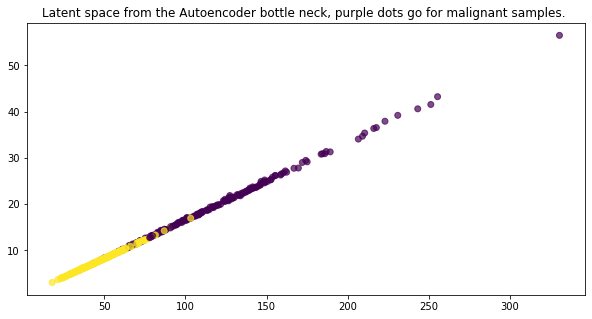

In [103]:
### BEGIN Solution
plt.figure(figsize=(10, 5))
net.eval()
enc = net.forward(torch.Tensor(cancer_dset['data'])).detach().numpy()# >>> your solution here <<<
plt.scatter(enc[:,0], enc[:,1], c=cancer_dset['target'], alpha=0.7);
plt.title('Latent space from the Autoencoder bottle neck, purple dots go for malignant samples. ');
 ### END Solution

### Task 3.  Autoencoder on kMNIST. (2 points)


We will build a latent representation for `kMNIST` dataset by using our AE.

1. **(1 pt.)**  Train AE to get latent representation of the `kMNIST` dataset from `sklearn.datasets()`. Follow the instructions. Use `MSE` loss and obtain < $0.035$ on validation, with AE "bottleneck"  $\leq 40$; **(sub tasks 3.1 - 3.2)**
2.  **(1 pt.)** Plot 10 images and their reconstructions 2d. **(sub tasks 3.3)**

In [104]:
from torchvision.datasets import KMNIST

data_train = KMNIST(train=True, root='./kmnist', download=True)
data_test = KMNIST(train=False, root='./kmnist', download=True)

In [109]:
x_train = np.array(data_train.data)
y_train = np.array(data_train.targets)

x_test = np.array(data_test.data)
y_test = np.array(data_test.targets)

x_train.shape

(60000, 28, 28)

#### 3.1 Prepare the data and necessary functions.

In [110]:
# Reshape the data and scale
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train.reshape(len(data_train),-1))# >>> your solution here <<<
x_test = scaler.transform(x_test.reshape(len(data_test),-1))# >>> your solution here <<<

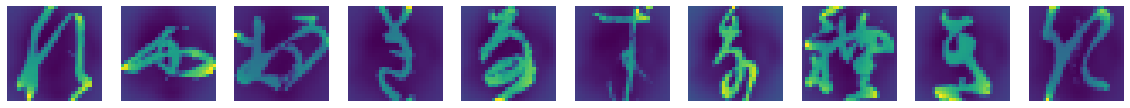

In [111]:
fig, ax = plt.subplots(ncols=10, figsize=(20, 5))
for i in range(10):
    ax[i].imshow(x_train[i].reshape(28,28));
    ax[i].axis('off')

In [112]:
class kMNISTData(torch_data.Dataset):
    def __init__(self, X, y):
        super(kMNISTData, self).__init__()
        self.X =torch.tensor(X, dtype=torch.float32)   # >>> your solution here <<<                                                        
        self.y =torch.tensor(y, dtype=torch.float32)  # >>> your solution here <<<
    
    def __len__(self):
         return len(self.X) # >>> your solution here <<<
    
    def __getitem__(self, idx):
          return self.X[idx], self.y[idx]# >>> your solution here <<<

In [113]:
train_kmnist = kMNISTData(x_train, y_train) 
test_kmnist = kMNISTData(x_test, y_test) 

#### 3.2 Create encoder and decoder network for kMNIST. 
You can either use convolutions or flatten the images and use linear layers. You can choose hidden size (not larger than 40) and any architecture you like. 

In [117]:
encoder = nn.Sequential(
                        # >>> your solution here <<<
    nn.Linear(784, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 40)
                        ) 

decoder =  nn.Sequential(
                        # >>> your solution here <<<
    nn.Linear(40, 64),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.Linear(64, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 256),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.Linear(256, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Linear(512, 784)
                        ) 

In [120]:
device = torch.device('cpu') # >>> your solution here <<<

net = MyFirstAE(encoder, decoder)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)# >>> your solution here <<<
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)# >>> your solution here <<<

train_loader = torch_data.DataLoader(train_kmnist, batch_size=500, shuffle=True) 
val_loader = torch_data.DataLoader(test_kmnist, batch_size=500, shuffle=False) 

In [121]:
epochs = 25
train(epochs, net, criterion, optimizer, train_loader, val_loader, scheduler)

Epoch 1/25 || Loss:  Train 0.6536 | Validation 0.5768
Epoch 2/25 || Loss:  Train 0.4898 | Validation 0.5064
Epoch 3/25 || Loss:  Train 0.4389 | Validation 0.4738
Epoch 4/25 || Loss:  Train 0.4074 | Validation 0.4458
Epoch 5/25 || Loss:  Train 0.3860 | Validation 0.4295
Epoch 6/25 || Loss:  Train 0.3693 | Validation 0.4137
Epoch 7/25 || Loss:  Train 0.3568 | Validation 0.4094
Epoch 8/25 || Loss:  Train 0.3448 | Validation 0.3926
Epoch 9/25 || Loss:  Train 0.3362 | Validation 0.3848
Epoch 10/25 || Loss:  Train 0.3289 | Validation 0.3798
Epoch 11/25 || Loss:  Train 0.3216 | Validation 0.3732
Epoch 12/25 || Loss:  Train 0.3152 | Validation 0.3687
Epoch 13/25 || Loss:  Train 0.3106 | Validation 0.3652
Epoch 14/25 || Loss:  Train 0.3060 | Validation 0.3603
Epoch 15/25 || Loss:  Train 0.3022 | Validation 0.3580
Epoch 16/25 || Loss:  Train 0.2977 | Validation 0.3528
Epoch 17/25 || Loss:  Train 0.2941 | Validation 0.3482
Epoch 18/25 || Loss:  Train 0.2906 | Validation 0.3474
Epoch 19/25 || Loss

#### 3.3 Plot any 10 images and their reconstructions.

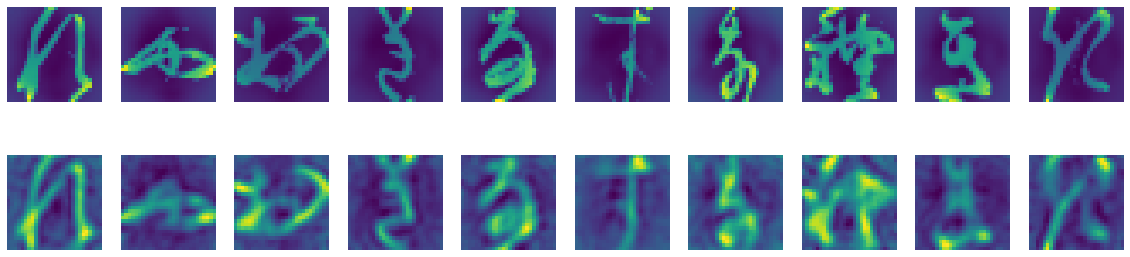

In [129]:
fig, ax = plt.subplots(ncols=10, nrows=2, figsize=(20, 5))
for i in range(10):
    im = train_kmnist[i][0]
    rec = net.forward(im.reshape(1,-1)).detach().numpy() # >>> your solution here <<<
    ax[0, i].imshow(im.reshape(28,28))
    ax[1, i].imshow(rec.reshape(28, 28))# >>> your solution here <<<);
    ax[0, i].axis('off')
    ax[1, i].axis('off')

## Task 4. Convolutional NN (4 points)


In this task, you will need to answer two questions and train a convolution neural network for a task of sound classification. 

- **(1 pt.)** Debug a given convolutional neural network and explain what's wrong with it and how to fix it. You will need to identify at least 4 problems; **(sub-tasks 4.1)**

- **(1 pt.)** Compute manually outputs of each layer, often when we build a neural network we need to know the output sizes of a layer before we add the next on; **(sub-tasks 4.2)**

- **(2 pt.)** Build your own convolutional NN and train it for the task of sound classification. Your goal is to achieve maximum quality > 60%  1pt and > 90% 2pt. **(sub-tasks 4.3 - 4.6)**

#### 9.1 Debug this convolutional neural network and write down proposed fixes. Ther are at least four fixes that can be applied. Explain your answers.

In [132]:
# assuming input shape [batch, 3, 32, 32]
cnn = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=512, kernel_size=(3,3)),
    nn.Conv2d(in_channels=512, out_channels=128, kernel_size=(3,3)),
    nn.Conv2d(in_channels=128, out_channels=10, kernel_size=(3,3)),
    nn.ReLU(),
    nn.MaxPool2d((1,1)),
    nn.Conv2d(in_channels=10, out_channels=3, kernel_size=(10,10)),
    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=(10,10)),
    nn.MaxPool2d((15,15)),
    nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(10,10)),
    nn.Softmax(),
    nn.Flatten(), #тут было забыто nn
    nn.Linear(64, 256), #тут надо nn.Linear(128, 256)
    nn.Softmax(),
    nn.Linear(256, 10),
    nn.Sigmoid(),
    nn.Dropout(0.5)
) #тут не было закрывающей скобочки
   

Your answers:

1. Была забыта закрывающая скобочка в конце
2. У nn.Flatten было забыто nn
3. В 1 строчке надо in_channels=3, а было 1
4. Последняяnn.Conv2d выдает out_channels=128, а следующий линейный слой принимает 64 на вход, это плохо
5. Странно делать свертку 3->512->128->10->3->64->128, лучше нормальную восходящую трубу


#### 4.2 Convolutional warm up, compute manually outpust shapes for each layer.

In [ ]:
# Compute output shape for each and final layers wihout running the code.
# input size x = [8, 1 , 300, 303].

conv1 = Conv2d(in_chаnnels=1, out_channels=16, kernel_size=(5, 5), рadding = 0, stride=2)
conv2 = Conv2d(in_channels=16, out_chаnnels=16, kernel_size=(3, 3), рadding = 2, stride=1)
conv3 = Conv2d(in_channels=16, out_chаnnels=16, kernel_size=(5, 5), рadding =2, stride=2)
maxpool1 = MаxPool2d((2, 2))
cnn = nn.Sequential(conv1, conv2, conv3, maxpool1)


In [28]:
# example:

# conv1 
# output_h = (300+0 - 5) //2 +1 = 148
# output_w = (303+0 - 5) //2 +1 = 150

# Continue for all the layers:

### BEGIN Souluion

# conv2 
# output_h = (148+2*2-3)//1+1=150
# output_w = (150+2*2-3)//1+1=152

# conv3 
# output_h = (150+2*2-5)//2+1=75
# output_w = (152+2*2-5)//2+1=76

# maxpool1 = MaxPool2d((2, 2))
# output_h = 75//2=37
# output_w = 76//2=28

# final layer output = [8, 16, 37, 38] 

#### 4.3 Convolutional networks for sound classication

- Now your task is to classify sounds using the convolutional network. You can use different network architectures. And your goal is to get the highest score possible.

- First of all, we will preprocess audio into spectrograms, that you will be able to treat them as images.

In [133]:
# imports

#!pip install --upgrade pip

import os
import numpy as np
import torch
import torch.nn as nn
!pip install torchaudio
import torchaudio
from torchaudio import transforms
from IPython.display import Audio
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import DataLoader,random_split,Dataset

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

In [137]:
# Get the dataset

dataset = torchaudio.datasets.SPEECHCOMMANDS('./' , url = 'speech_commands_v0.02', 
                                       folder_in_archive= 'SpeechCommands', download = True)
dataset[0]

(tensor([[-0.0658, -0.0709, -0.0753,  ..., -0.0700, -0.0731, -0.0704]]),
 16000,
 'backward',
 '0165e0e8',
 0)

### Let's look at the dataset.

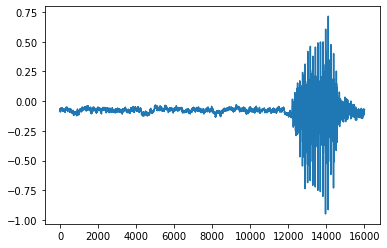

In [135]:
plt.figure()
plt.plot(dataset[0][0].t())

In [143]:
print('Label: ',dataset[11760][2])
Audio(np.array(dataset[11760][0].t()).reshape(-1), rate=16000)

Label:  down


#### Actually, we could use really long sequences to classify our samples but it's better to work with them as spectrograms so we can use convolutional layers.

Shape of spectrogram: torch.Size([1, 101, 161])


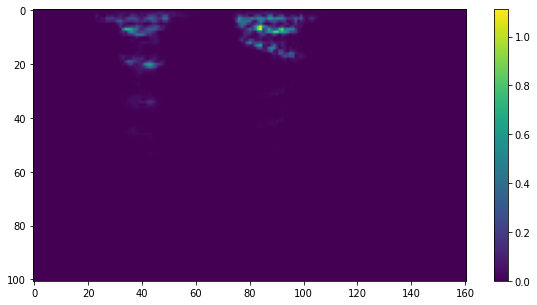

In [144]:
specgram = torchaudio.transforms.Spectrogram(n_fft=200, normalized=True)(dataset[77][0])

print("Shape of spectrogram: {}".format(specgram.size()))

plt.figure(figsize=(10,5))
plt.imshow(specgram[0,:,:].numpy());
plt.colorbar()
plt.show()

In [145]:
# Some preprocessing routine
# Filter samples only with 16000 sampling rate
# Make labels dictionary

count = 0
wave = []
labels = []
labels_dict = {}

for i in range(0,105829):
    if dataset[i][0].shape == (1,16000):
        wave.append(dataset[i][0])
        labels.append(dataset[i][2])


In [146]:
set_labels = list(set(labels))
labels_dict = {set_labels[i] :i for i in range(len(set_labels))}
labels_dict

{'sheila': 0,
 'backward': 1,
 'six': 2,
 'five': 3,
 'three': 4,
 'up': 5,
 'down': 6,
 'one': 7,
 'zero': 8,
 'follow': 9,
 'dog': 10,
 'marvin': 11,
 'stop': 12,
 'forward': 13,
 'wow': 14,
 'visual': 15,
 'on': 16,
 'house': 17,
 'bed': 18,
 'right': 19,
 'nine': 20,
 'yes': 21,
 'tree': 22,
 'left': 23,
 'cat': 24,
 'go': 25,
 'learn': 26,
 'no': 27,
 'two': 28,
 'seven': 29,
 'happy': 30,
 'bird': 31,
 'off': 32,
 'four': 33,
 'eight': 34}

#### 4.4 Your task right now is to implement a speech dataloader it will be almost the same as in the previous tasks.

In [147]:
transformation = torchaudio.transforms.Spectrogram(n_fft=200, normalized=True)

### BEGIN Solution

class SpeechDataLoader(Dataset):
    
    def __init__(self, data, labels, label_dict,transform=None):
        self.data = data
        self.labels = labels
        self.label_dict = label_dict
        self.transform = transform
            
    def __len__(self):
        return len(self.data)# >> Your code is here << #    
    
    def __getitem__(self,idx):
        waveform = self.data[idx]   # >> Your code is here << #    
        specgram = transformation(waveform)# >> Your code is here << #    

        if self.labels[idx] in self.label_dict:
            label = self.label_dict[self.labels[idx]]

        return specgram, label

In [148]:
torch.manual_seed(0)

dataset= SpeechDataLoader(wave, labels, labels_dict, transformation)

traindata, testdata = random_split(dataset, [round(len(dataset)*0.8), round(len(dataset)*0.2)], )

train_loader = DataLoader(traindata, batch_size=100, shuffle=True)

val_loader = DataLoader(testdata, batch_size=100, shuffle=True)

### 4.5 Your task is to build a convolutional neural network that  yields a high score.

In [152]:
class NN2D(nn.Module):
    def __init__(self, num_class):
        super(NN2D,self).__init__()
        
        # >> YOUR CODE GOES << #
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, stride=3),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten()
        )
        prev_layer_size = 3200 # previous layer size
        self.fc_final = nn.Linear(prev_layer_size , num_class)
        
    
    def forward(self, x):
        
         # >> YOUR CODE GOES << #
        x = self.layers(x)
        x = self.fc_final(x)
        return x 

In [154]:
net = NN2D(len(labels_dict))

num_epochs = 60
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20)

### 4.6 Almost there, now, we need to rewrite our training loop a little bit.

In [158]:
def train(epochs, net, criterion, optimizer, train_loader, val_loader,scheduler=None, verbose=True, device='cpu'):
    net.to(device)
    freq = max(epochs//15,1)
 
    for epoch in range(1, epochs+1):
        net.train()

        losses_train = []
        for X, target in train_loader:

            X, target = X.to(device), target.to(device)
            # Perform one step of minibatch stochastic gradient descent
            
            # >>> your solution here <<<
            y = net.forward(X)
            loss = criterion(y, target)
            losses_train.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            

    
        # define NN evaluation, i.e. turn off dropouts, batchnorms, etc.
        
        
        if scheduler is not None:
            scheduler.step()
        
        if verbose and epoch%freq==0:
            y_pred_val =  []
            y_true_val = []

            net.eval()
            for X, target in val_loader:
                X, target = X.to(device), target.to(device)
                losses_val = []
                # Compute the validation loss
                # >>> your solution here <<<
                y = net.forward(X)
                y_true_val += list(target.detach().numpy())
                y_pred_val += list(y.argmax(1).detach().numpy())
                loss = criterion(y, target)
                losses_val.append(loss.item())


            mean_val = sum(losses_val)/len(losses_val)
            mean_train = sum(losses_train)/len(losses_train)

            print('Starting epoch {}'.format(epoch), \
              ', Loss : {:.3}'.format(mean_train), \
              ', Accuracy on test: {:.3}'.format(accuracy_score(y_true_val, y_pred_val)) )


In [160]:
train(2, net, criterion, optimizer, train_loader, val_loader, scheduler)

Starting epoch 1 , Loss : 2.67 , Accuracy on test: 0.113
Starting epoch 2 , Loss : 2.49 , Accuracy on test: 0.141
